1. Data loading and cleaning
2. Base Neural Network
    1. Multilayer Perceptron (MLP) Regression
    2. MLP for binary classification
    3. MLP for multiclass classification

In [1]:
# Connect with Kaggle API

"""import kaggle
kaggle.api.authenticate()

kaggle.api.dataset_download_files('camnugent/california-housing-prices', path='.', unzip=True)"""


"import kaggle\nkaggle.api.authenticate()\n\nkaggle.api.dataset_download_files('camnugent/california-housing-prices', path='.', unzip=True)"

In [2]:
import pandas as pd

# Load the data
data = pd.read_csv('data/california_houses/housing.csv')
# Display header
print(f'Header of the dataset {data.head()} \n')
# Check for missing values
print(f'Check for the presence of null data: {data.isnull().sum()}')

print(f'Shape of the dataset: {data.shape}')


Header of the dataset    longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY   

Check for the presence of null data: longitude     

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
# Discard missin values
data = data.dropna()
print(f'Check for the presence of null data: {data.isnull().sum()}')


Check for the presence of null data: longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


In [5]:
# Check the categorical variable
print(f'ocean_proximity column: {data["ocean_proximity"].unique()}')

ocean_proximity column: ['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']


In [6]:
# Transform the categorical variable into aon-hot encoding

data = pd.get_dummies(data, columns=['ocean_proximity'])
print(f'Variables type BEFORE: \n  {data.iloc[:,-5:].info()} \n')


dummy_columns = [col for col in data.columns if col.startswith('ocean_')]
data[dummy_columns] = data[dummy_columns].astype(int)


print(f'Variables type AFTER: \n  {data.iloc[:,-5:].info()} \n')

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ocean_proximity_<1H OCEAN   20433 non-null  bool 
 1   ocean_proximity_INLAND      20433 non-null  bool 
 2   ocean_proximity_ISLAND      20433 non-null  bool 
 3   ocean_proximity_NEAR BAY    20433 non-null  bool 
 4   ocean_proximity_NEAR OCEAN  20433 non-null  bool 
dtypes: bool(5)
memory usage: 259.4 KB
Variables type BEFORE: 
  None 

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ocean_proximity_<1H OCEAN   20433 non-null  int64
 1   ocean_proximity_INLAND      20433 non-null  int64
 2   ocean_proximity_ISLAND      20433 non-null  int64
 3   ocean_proximity_NEAR BAY    20433 non-null  int64
 4   oc

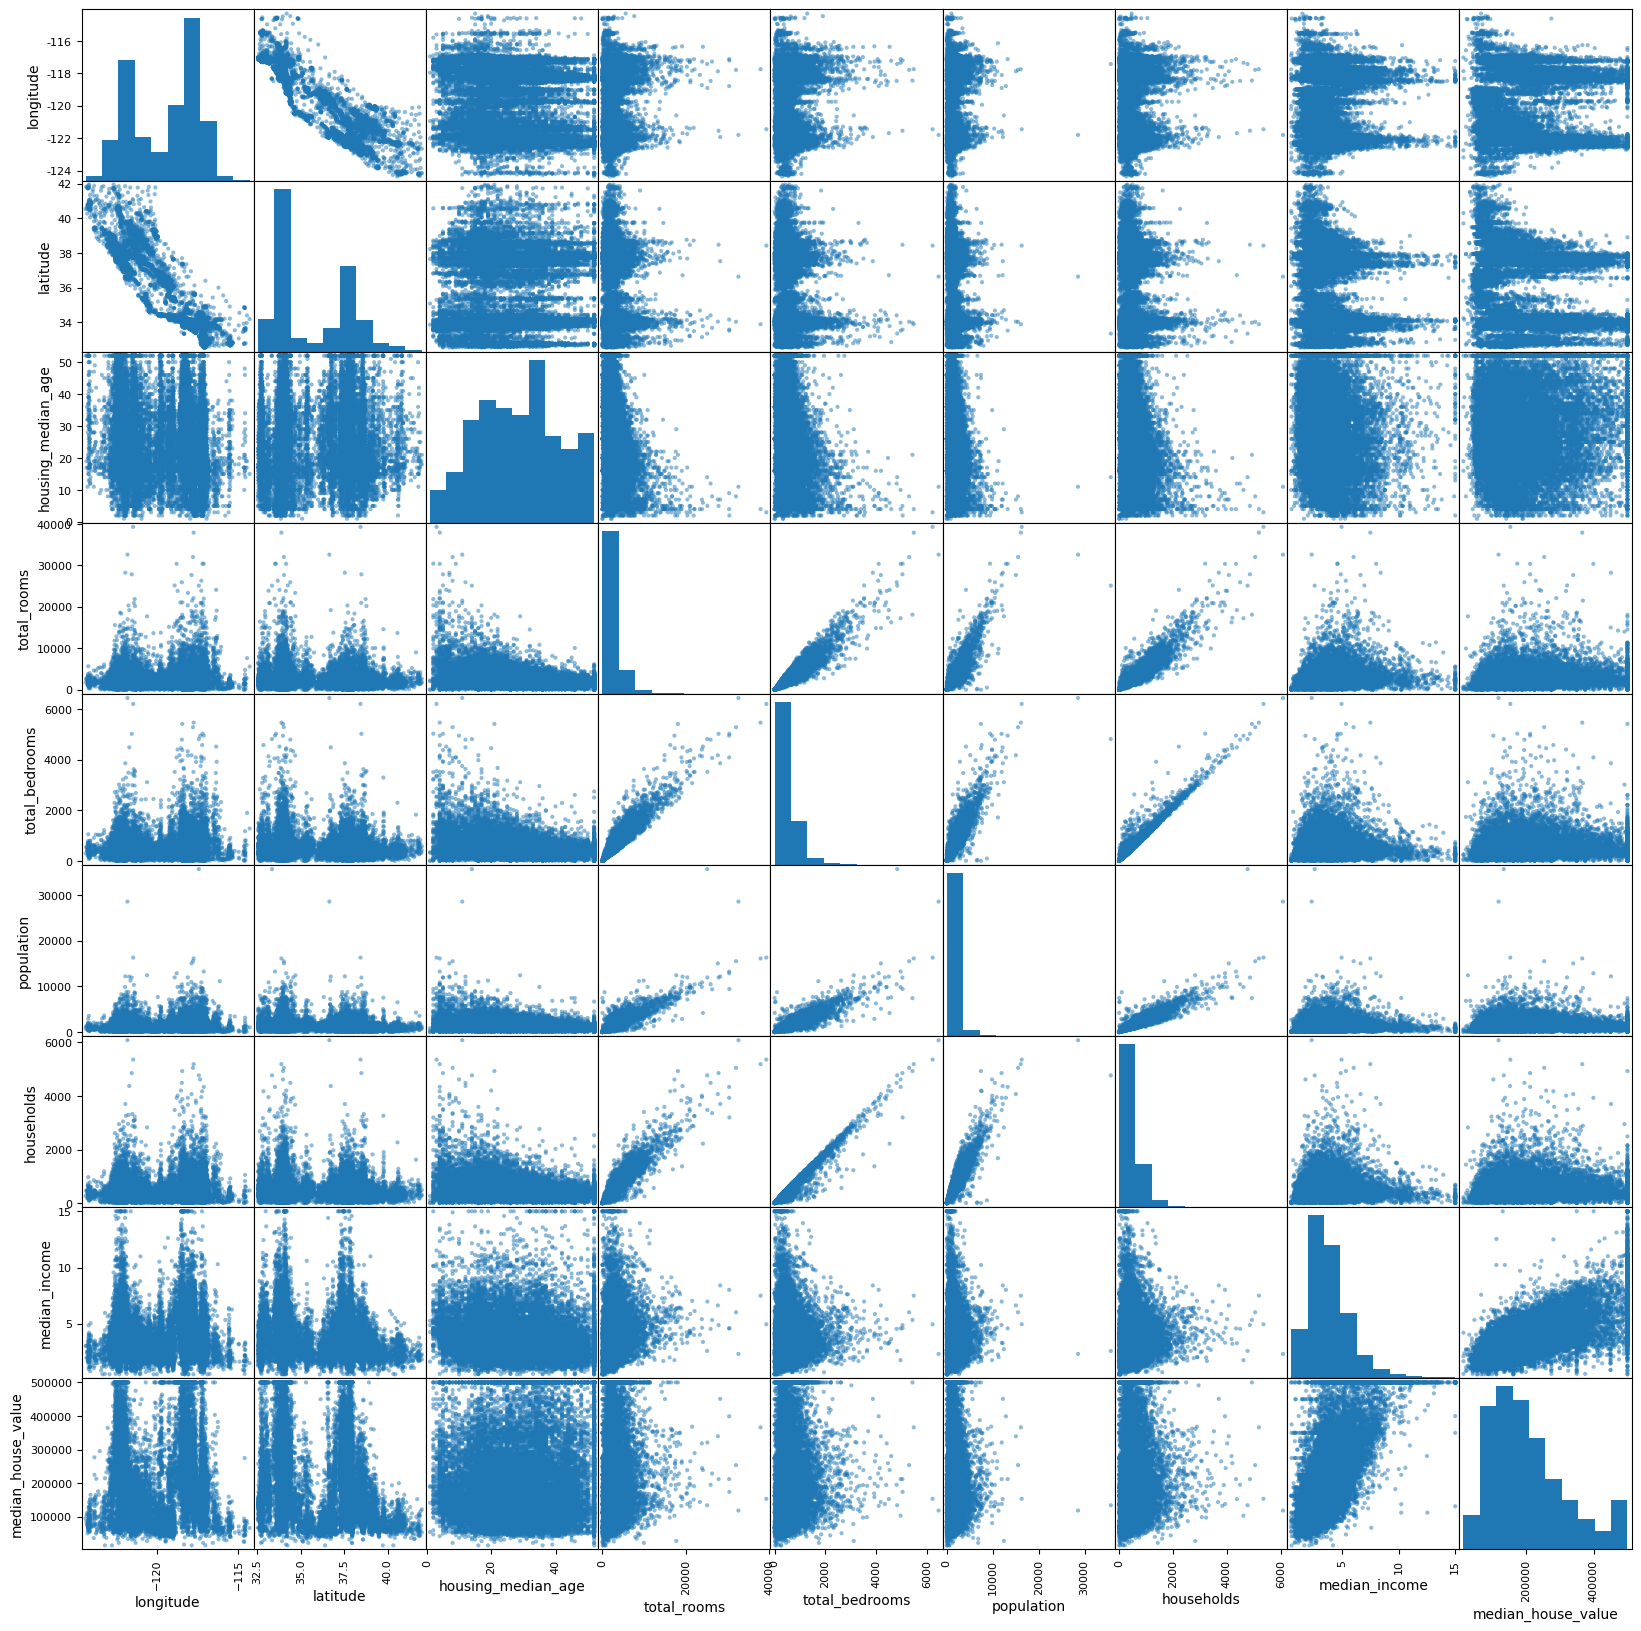

In [7]:
# Plot the distribution of the variables

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt


scatter_matrix(data.iloc[:,:-5], alpha=0.5, figsize=(20, 20))
plt.show()

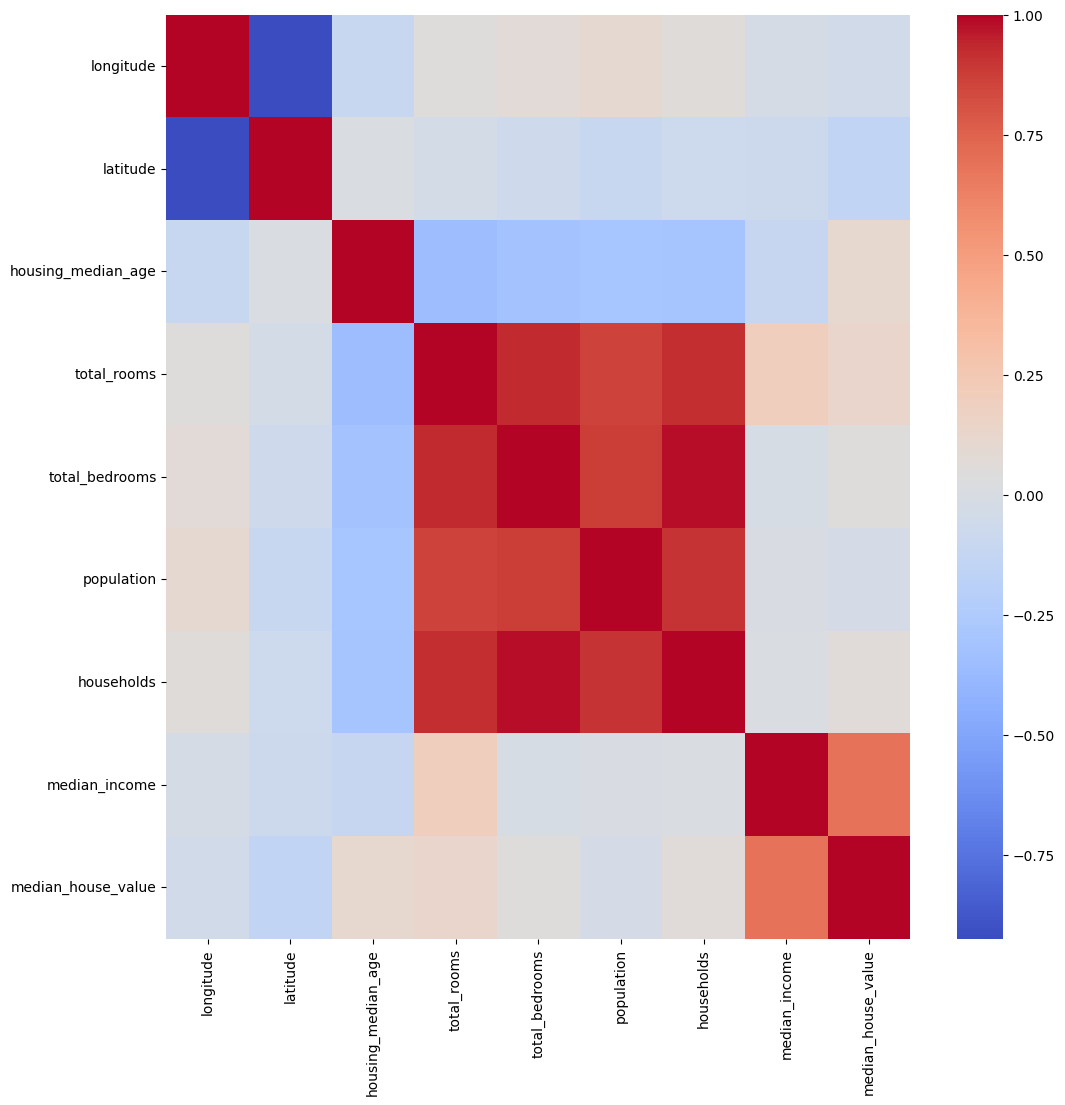

In [8]:
# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (12, 12))
sns.heatmap(data.iloc[:,:-5].corr(), cmap='coolwarm', xticklabels=data.iloc[:,:-5].columns, yticklabels=data.iloc[:,:-5].columns)
plt.show()

### MLP from scratch

In [9]:
# Splitting and standardizing the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = data.drop('median_house_value', axis=1)
y = data['median_house_value']

y_mean = y.mean()
y_std = y.std()

X_scal = StandardScaler().fit_transform(X)
y_scal = StandardScaler().fit_transform(y.values.reshape(-1, 1))

X_train, X_temp, y_train, y_temp = train_test_split(X_scal, y_scal, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [10]:
# Implement the Dataset
import torch
from torch.utils.data import Dataset, DataLoader

class housesDataset(Dataset):

    def __init__(self, X, y):

        self.X = X
        self.y = y
        
    def __len__(self):

        return len(self.X)
    
    def __getitem__(self, idx):

        return self.X[idx], self.y[idx]

In [11]:
# Create the dataset instances

train_data = housesDataset(X_train, y_train)
val_data = housesDataset(X_val, y_val)
test_data = housesDataset(X_test, y_test)

In [12]:
print(f'The first element of the dataset is: {next(iter(train_data))}')

The first element of the dataset is: (array([-1.11269243,  0.78958123, -1.16214088,  0.81250352,  0.91635638,
        1.12343335,  1.02426605,  0.43782582,  1.12329373, -0.68271329,
       -0.01564487, -0.35352419, -0.38418614]), array([0.17963334]))


In [20]:
# Implement the MLP model

import torch.nn as nn

class HousesMLP(nn.Module):

    def __init__(self, input_size, drop = 0.0, deep = False):

        self.drop = drop
        self.deep = deep

        super(HousesMLP, self).__init__()

        self.l1 = nn.Linear(input_size, 128)
        self.l2 = nn.Linear(128, 64)

        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        if self.deep:
            # Additional layers for deep architecture
            self.deep_layers = nn.Sequential(
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Dropout(self.drop),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 1),
            )
        else:
            # Single output layer for shallow architecture
            self.output_layer = nn.Linear(64, 1)

    def forward(self, x):  

        if self.deep:
            return self.deep_layers(self.model(x))      

        else:
            return self.output_layer(self.model(x))
        
    def init_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)

In [14]:
# Create the function that will train the model
import numpy as np
from sklearn.metrics import r2_score

def train_model(model, dataloader, optimizer, criterion, phase, device, weight = False):

    if phase == 'train':
        model.train() # Set the model in training mode
    else:
        model.eval() # Set the model in evaluation mode

    running_loss = [] # Initialise the running losses for each batch
    
    for i, instance in enumerate(dataloader):

        X, y = instance
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):

            y_pred = model(X.float())
            if type(weight) != bool:
                loss = criterion(y_pred.float(), y.float()).to('cpu')
            else:
                loss = criterion(y_pred.float(), y.float()).to('cpu')

            if phase == 'train':
                loss.backward()
                optimizer.step()

        
        running_loss.append(loss.item())

      # Computing loss and accuracy
    batch_loss = np.asarray(running_loss).mean()
    batch_r2 = r2_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())

    return batch_loss, batch_r2

In [15]:
# Create the main training loop

import warnings
import sys
warnings.filterwarnings("ignore")

input_size = X_train.shape[1]
num_epochs = 120
num_workers = 8
batch_size = 128

device = 'cuda:1'

criterion = nn.MSELoss()
#criterion = nn.SmoothL1Loss()

lr = 1e-4

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
valid_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

model = HousesMLP(input_size)
model.cuda(1)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_losses = []
train_r2 = []

val_losses = []
val_r2 = []

test_losses = []
test_r2 = []

for epoch in range(num_epochs):
    
    train_loss, train_r2_score = train_model(model, train_dataloader, optimizer, criterion, 'train', device)
    test_loss, test_r2_score = train_model(model, test_dataloader, optimizer, criterion, 'test', device)

    train_losses.append(train_loss)
    train_r2.append(train_r2_score)

    test_losses.append(test_loss)
    test_r2.append(test_r2_score)

    print(f'Epoch {epoch + 1}/{num_epochs} \n'
          f'Train loss: {train_loss:.4f} | Train R2: {train_r2_score:.4f} \n'
          f'Test loss: {test_loss:.4f} | Test R2: {test_r2_score:.4f} \n')
          #f'Test MAPE {np.mean(np.abs((y_true - y_pred) / y_true)) * 100} \n')


Epoch 1/120 
Train loss: 0.7950 | Train R2: 0.2945 
Test loss: 0.6121 | Test R2: 0.3381 

Epoch 2/120 
Train loss: 0.4666 | Train R2: 0.6250 
Test loss: 0.3852 | Test R2: 0.5552 

Epoch 3/120 
Train loss: 0.3637 | Train R2: 0.6576 
Test loss: 0.3450 | Test R2: 0.5875 

Epoch 4/120 
Train loss: 0.3381 | Train R2: 0.6507 
Test loss: 0.3289 | Test R2: 0.5970 

Epoch 5/120 
Train loss: 0.3231 | Train R2: 0.7855 
Test loss: 0.3149 | Test R2: 0.6167 

Epoch 6/120 
Train loss: 0.3134 | Train R2: 0.6660 
Test loss: 0.3080 | Test R2: 0.6197 

Epoch 7/120 
Train loss: 0.3047 | Train R2: 0.6082 
Test loss: 0.3027 | Test R2: 0.6277 

Epoch 8/120 
Train loss: 0.2983 | Train R2: 0.7158 
Test loss: 0.2962 | Test R2: 0.6311 

Epoch 9/120 
Train loss: 0.2929 | Train R2: 0.6123 
Test loss: 0.2940 | Test R2: 0.6363 

Epoch 10/120 
Train loss: 0.2878 | Train R2: 0.6855 
Test loss: 0.2884 | Test R2: 0.6398 

Epoch 11/120 
Train loss: 0.2832 | Train R2: 0.6397 
Test loss: 0.2865 | Test R2: 0.6360 

Epoch 12

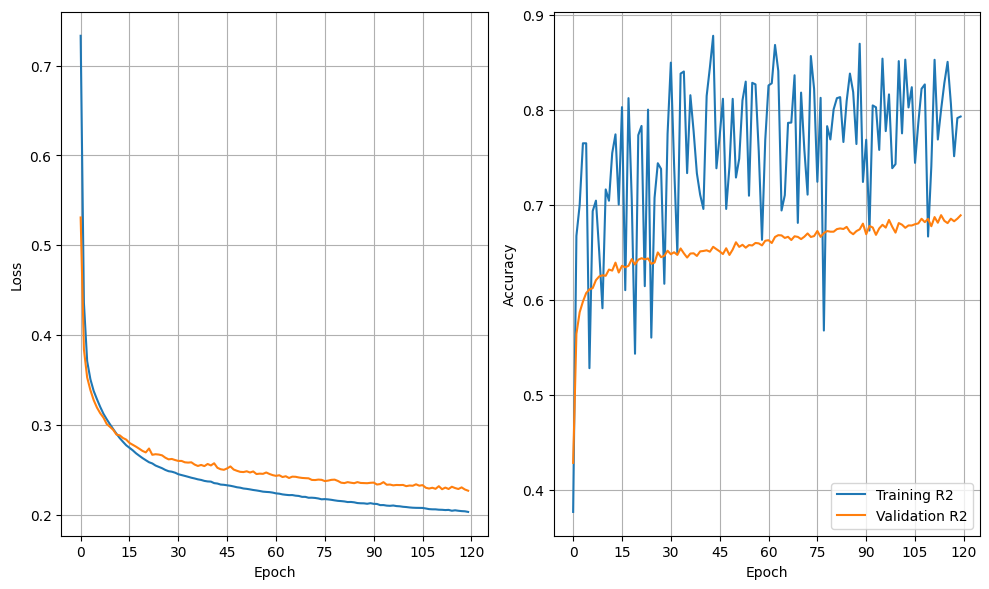

In [162]:
# Plot the losses
from matplotlib.ticker import MaxNLocator

def plot_performance(train_losses, test_losses, train_r2, test_r2):

    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    axes[0].plot(train_losses, label='Training Loss')
    axes[0].plot(test_losses, label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[0].grid(True)

    axes[1].plot(train_r2, label='Training R2')
    axes[1].plot(test_r2, label='Validation R2')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[1].grid(True)

    plt.legend()
    plt.tight_layout()
    plt.show()


plot_performance(train_losses, test_losses, train_r2, test_r2)

In [16]:
# Compute R2 score on the validation set ad compare it with the test set

def compute_val_r2(model, dataloader, criterion, device):

    tot_val_r2 = []

    for i, instance in enumerate(dataloader):

        X, y = instance
        X, y = X.to(device), y.to(device)

        y_pred = model(X.float())
        #val_loss = criterion(y_pred.float(), y.float()).to('cpu')

        val_r2_score = r2_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())
        tot_val_r2.append(val_r2_score)

    return np.mean(tot_val_r2)

tot_val_r2 = compute_val_r2(model, valid_dataloader, criterion, device)

print(f'Validation R2 score: {np.mean(tot_val_r2):.3f}')



Validation R2 score: 0.777


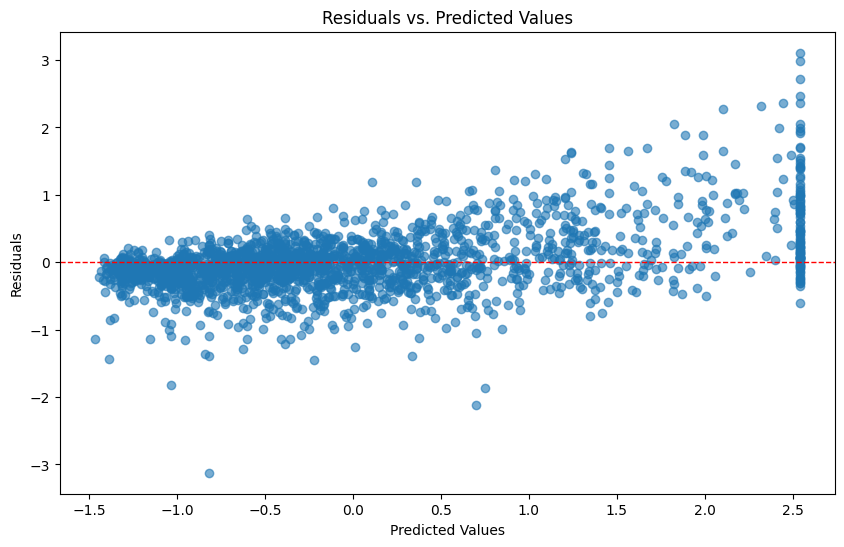

In [17]:
# Plot residuals to check how the model is performing

def residuals(model, dataloader, device):
    
    residuals = []
    y_val = []

    for i, instance in enumerate(dataloader):

        X, y = instance
        X, y = X.to(device), y.to(device)

        y_pred = model(X.float())

        y_val.extend(y.cpu().detach().numpy())

        residuals.append(y.cpu().numpy() - y_pred.detach().cpu().numpy())

    residuals = np.concatenate(residuals)

    return residuals, y_val


residuals_mlp, y_val = residuals(model, valid_dataloader, device)

plt.figure(figsize=(10, 6))
plt.scatter(y_val, residuals_mlp, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()


In [165]:
# Try a standard linear regression model

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(f'R2 score {r2_score(y_test, y_pred):.3f}')

R2 score 0.662


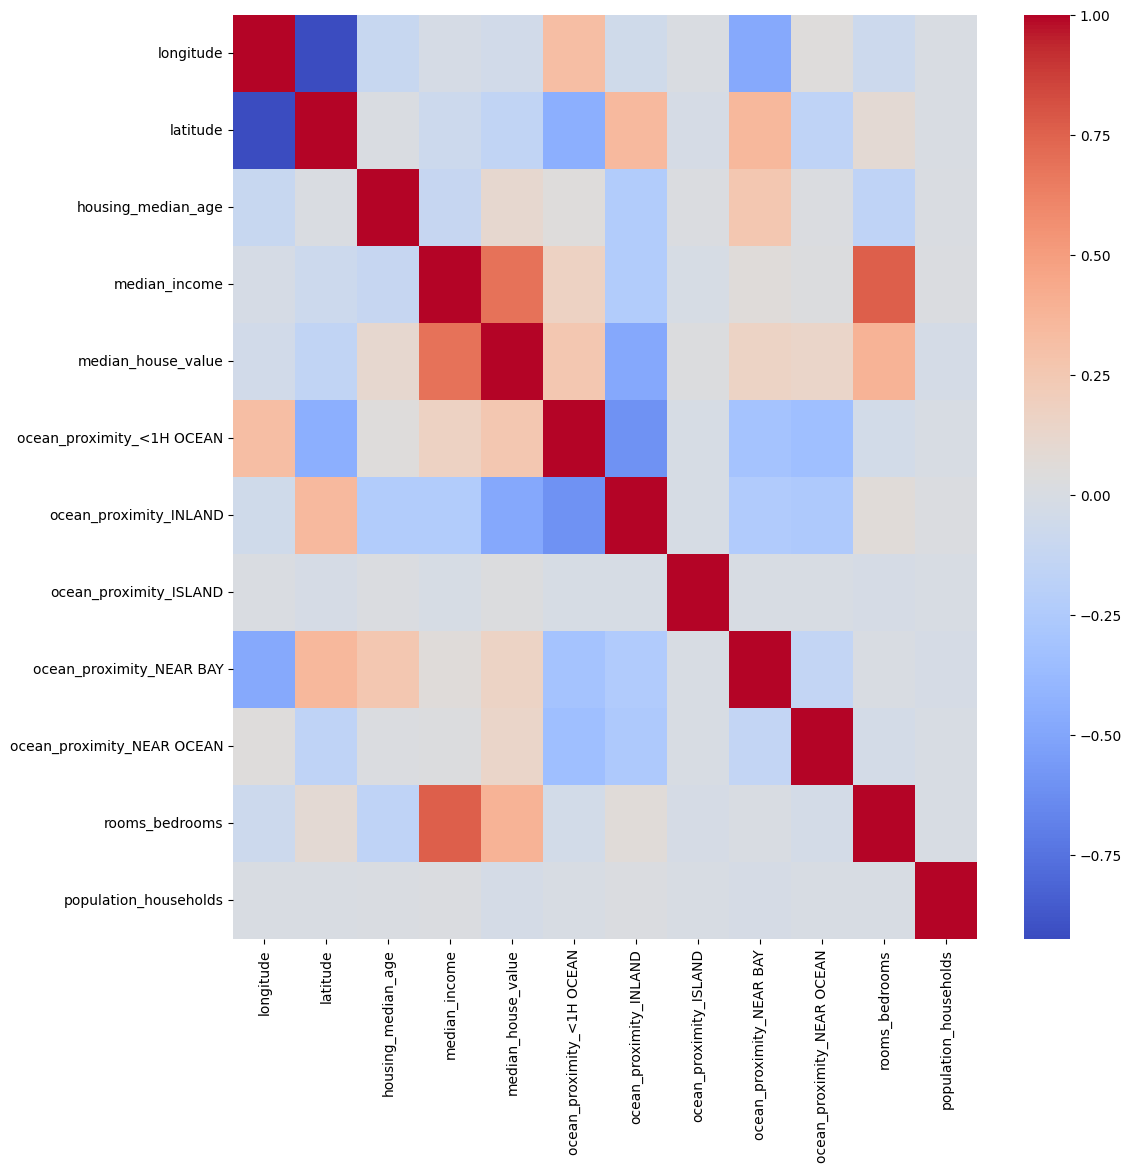

In [18]:
data_new = data.copy()

#1. Feature engineering --> reduce feature correlation problem!

data_new['rooms_bedrooms'] = data_new['total_rooms']/data_new['total_bedrooms']
data_new['population_households'] = data_new['population']/data_new['households']

data_new.drop(['total_rooms', 'total_bedrooms', 'population', 'households'], axis=1, inplace=True)

# Plot the correlation matrix

plt.figure(figsize = (12, 12))
sns.heatmap(data_new.corr(), cmap='coolwarm', xticklabels=data_new.columns, yticklabels=data_new.columns)
plt.show()


In [19]:
# Logarithm transformation of the target variable

from sklearn.preprocessing import Normalizer

X = data_new.drop('median_house_value', axis=1)
y = data_new['median_house_value']

#2. Logarithm transformation of the target variable
y = np.log1p(y)

X_scal = StandardScaler().fit_transform(X)
y_scal = StandardScaler().fit_transform(y.values.reshape(-1, 1))

X_train, X_temp, y_train, y_temp = train_test_split(X_scal, y_scal, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_data = housesDataset(X_train, y_train)
val_data = housesDataset(X_val, y_val)
test_data = housesDataset(X_test, y_test)

In [22]:
# Custom Weighted MSE Loss
class WeightedMSELoss(nn.Module):
    def __init__(self, weight):
        super(WeightedMSELoss, self).__init__()
        self.weight = weight
        
    def forward(self, y_pred, y_true):
        # Weighted Mean Squared Error
        loss =  self.weight * (y_pred - y_true)**2
        return loss.mean()

In [23]:
# Some improovements can be done to the model
input_size = X_train.shape[1]
lr = 1e-4
num_epochs = 200
device = 'cuda:1'
batch_size = 128

# Define weights for the WeightedMSELoss as the inverse of the variance of the residuals --> use the residuals of the other MLP model

res_train, _ = residuals(model, train_dataloader, device)
weight = 1/(np.var(res_train) + 1e-6)

# Implement a custom weighted loss function or L1 loss
#criterion = nn.SmoothL1Loss()
criterion = WeightedMSELoss(weight)

# Improove the depth of the model (add more layers) with a dropout layer to prevent overfitting
model = HousesMLP(input_size, drop=0.2, deep=True)
model.cuda(1)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 5. Implement early stopping to prevent overfitting
patience = 20
patience_counter = 0
best_loss = np.inf

train_losses = []
train_r2 = []

val_losses = []
val_r2 = []

test_losses = []
test_r2 = []

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
valid_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

for epoch in range(num_epochs):

    train_loss, train_r2_score = train_model(model, train_dataloader, optimizer, criterion, 'train', device)
    test_loss, test_r2_score = train_model(model, test_dataloader, optimizer, criterion, 'test', device)

    if test_loss > best_loss:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch: {epoch}' )
            break
    else:
        
        best_loss = test_loss
        patience_counter = 0

    train_losses.append(train_loss)
    train_r2.append(train_r2_score)

    test_losses.append(test_loss)
    test_r2.append(test_r2_score)

    print(f'Epoch {epoch + 1}/{num_epochs} \n'
        f'Train loss: {train_loss:.4f} | Train R2: {train_r2_score:.4f} \n'
        f'Test loss: {test_loss:.4f} | Test R2: {test_r2_score:.4f} \n'
        f'Patience counter: {patience_counter} \n')


Epoch 1/200 
Train loss: 4.5444 | Train R2: 0.2219 
Test loss: 3.7200 | Test R2: 0.2526 
Patience counter: 0 

Epoch 2/200 
Train loss: 2.5255 | Train R2: 0.5945 
Test loss: 1.9005 | Test R2: 0.5628 
Patience counter: 0 

Epoch 3/200 
Train loss: 1.8287 | Train R2: 0.6240 
Test loss: 1.6668 | Test R2: 0.6307 
Patience counter: 0 

Epoch 4/200 
Train loss: 1.6670 | Train R2: 0.7450 
Test loss: 1.5717 | Test R2: 0.6564 
Patience counter: 0 

Epoch 5/200 
Train loss: 1.5823 | Train R2: 0.7265 
Test loss: 1.5241 | Test R2: 0.6791 
Patience counter: 0 

Epoch 6/200 
Train loss: 1.5755 | Train R2: 0.6930 
Test loss: 1.5091 | Test R2: 0.6785 
Patience counter: 0 

Epoch 7/200 
Train loss: 1.5295 | Train R2: 0.6451 
Test loss: 1.5045 | Test R2: 0.6823 
Patience counter: 0 

Epoch 8/200 
Train loss: 1.5401 | Train R2: 0.7481 
Test loss: 1.5019 | Test R2: 0.6859 
Patience counter: 0 

Epoch 9/200 
Train loss: 1.5214 | Train R2: 0.7359 
Test loss: 1.4606 | Test R2: 0.6923 
Patience counter: 0 

E

In [25]:
from matplotlib.ticker import MaxNLocator

def plot_performance(train_losses, test_losses, train_r2, test_r2):

    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    axes[0].plot(train_losses, label='Training Loss')
    axes[0].plot(test_losses, label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[0].grid(True)

    axes[1].plot(train_r2, label='Training R2')
    axes[1].plot(test_r2, label='Validation R2')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[1].grid(True)

    plt.legend()
    plt.tight_layout()
    plt.show()

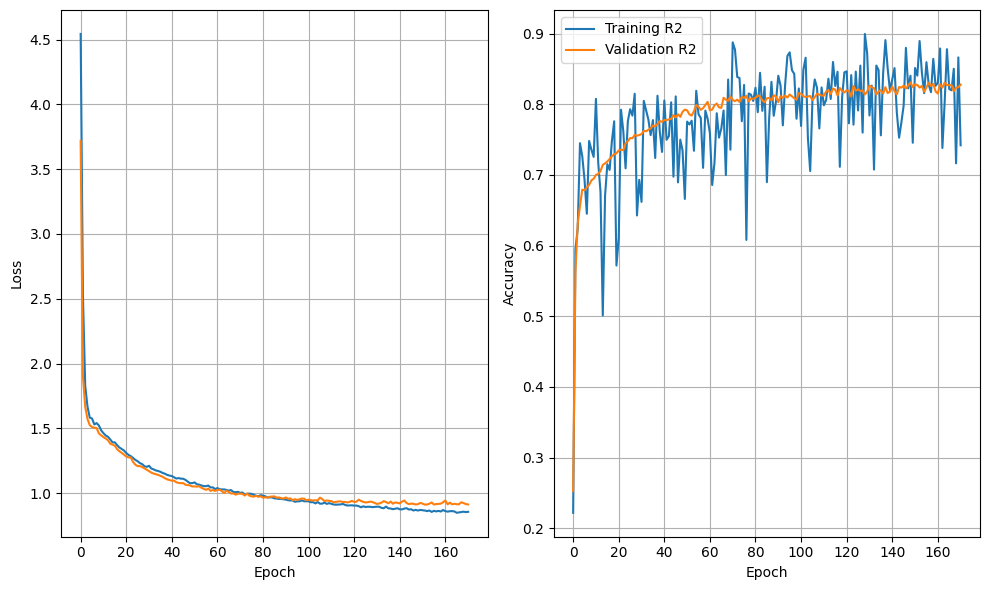

In [26]:
plot_performance(train_losses, test_losses, train_r2, test_r2)

In [27]:
imp_val_r2 = compute_val_r2(model, valid_dataloader, criterion, device)

print(f'Validation R2 score: {np.mean(imp_val_r2):.3f}')

Validation R2 score: 0.826


In [28]:
# MLP from sklearn
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=100, alpha=1e-4, solver='adam', random_state=30)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

print(f'LInear regression R2 score {r2_score(y_test, y_pred):.3f}')

LInear regression R2 score 0.823


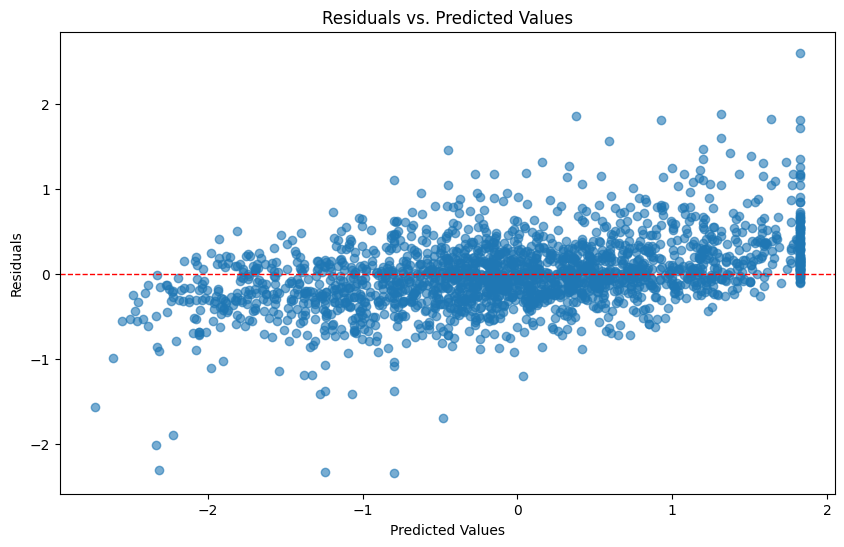

In [29]:
# Plot residuals

val_res, y_val = residuals(model, valid_dataloader, device)

plt.figure(figsize=(10, 6))
plt.scatter(y_val, val_res, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')

plt.show()


### Binary Classification

In [35]:
import pandas as pd

# Read the data

data = pd.read_csv('data/water/waterQuality1.csv')

print(f'Header of the dataset {data.head()} \n')

# Check for missing values
print(f'Check for the presence of null data: {data.isnull().sum()}')

Header of the dataset    aluminium ammonia  arsenic  barium  cadmium  chloramine  chromium  copper  \
0       1.65    9.08     0.04    2.85    0.007        0.35      0.83    0.17   
1       2.32   21.16     0.01    3.31    0.002        5.28      0.68    0.66   
2       1.01   14.02     0.04    0.58    0.008        4.24      0.53    0.02   
3       1.36   11.33     0.04    2.96    0.001        7.23      0.03    1.66   
4       0.92   24.33     0.03    0.20    0.006        2.67      0.69    0.57   

   flouride  bacteria  ...   lead  nitrates  nitrites  mercury  perchlorate  \
0      0.05      0.20  ...  0.054     16.08      1.13    0.007        37.75   
1      0.90      0.65  ...  0.100      2.01      1.93    0.003        32.26   
2      0.99      0.05  ...  0.078     14.16      1.11    0.006        50.28   
3      1.08      0.71  ...  0.016      1.41      1.29    0.004         9.12   
4      0.61      0.13  ...  0.117      6.74      1.11    0.003        16.90   

   radium  selenium  s

In [36]:
# Change Ammonia and is_safe from object to float

data['ammonia'] = pd.to_numeric(data['ammonia'], errors='coerce')
data['is_safe'] = pd.to_numeric(data['is_safe'], errors='coerce')

data = data.dropna()
data = data.drop(data[data['is_safe'] == '#NUM!'].index)
data = data.drop(data[data['ammonia'] == '#NUM!'].index)

data['is_safe'] = data['is_safe'].astype(int)


data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7996 entries, 0 to 7998
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   aluminium    7996 non-null   float64
 1   ammonia      7996 non-null   float64
 2   arsenic      7996 non-null   float64
 3   barium       7996 non-null   float64
 4   cadmium      7996 non-null   float64
 5   chloramine   7996 non-null   float64
 6   chromium     7996 non-null   float64
 7   copper       7996 non-null   float64
 8   flouride     7996 non-null   float64
 9   bacteria     7996 non-null   float64
 10  viruses      7996 non-null   float64
 11  lead         7996 non-null   float64
 12  nitrates     7996 non-null   float64
 13  nitrites     7996 non-null   float64
 14  mercury      7996 non-null   float64
 15  perchlorate  7996 non-null   float64
 16  radium       7996 non-null   float64
 17  selenium     7996 non-null   float64
 18  silver       7996 non-null   float64
 19  uranium    

In [37]:
from sklearn.model_selection import train_test_split

X = data.drop('is_safe', axis=1)
y = data['is_safe']

# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=30)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=30)

print(f'Number of samples in training set: {X_train.shape[0]}')
print(f'Number of samples in validation set: {X_val.shape[0]}')

Number of samples in training set: 6396
Number of samples in validation set: 800


In [38]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority', random_state=30)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
X_test_sm, y_test_sm = smote.fit_resample(X_test, y_test)

# Check for the output proportions after SMOTE
print(f'Enlarged dataset proportion {y_train_sm.value_counts()}')

Enlarged dataset proportion is_safe
0    5669
1    5669
Name: count, dtype: int64


In [39]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_sm) # X_train_sm, X_train_us, X_train 
X_test = scaler.transform(X_test_sm)    # X_test_sm, X_test_us, X_test
X_val = scaler.transform(X_val)

print(f'The length of the training dataset is: {len(X_train)}')
print(f'The length of the testing dataset is: {len(X_test)}')
print(f'The length of the validation dataset is: {len(X_val)}')


The length of the training dataset is: 11338
The length of the testing dataset is: 1432
The length of the validation dataset is: 800


In [40]:

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class MLP_dataset(Dataset):
    
    def __init__(self, data_file):
        
        self.data = np.array(data_file)
                  
        self.health_data = torch.from_numpy(self.data[:, :-1]).float()
        self.labels = torch.from_numpy(self.data[:, -1]).long()

    def __len__(self):
        return len(self.health_data)

    def __getitem__(self, index):
        health_data = self.health_data[index]
        label = self.labels[index]

        return health_data, label
    

In [41]:
# Create the dataset

train_dataset = MLP_dataset(np.c_[X_train, y_train_sm]) # X_train_sm --> y_train_sm, X_train_us --> y_train_sm, X_train
test_dataset = MLP_dataset(np.c_[X_test, y_test_sm])   # X_test_sm --> y_test_sm, X_test_us --> y_test_sm, X_test
val_dataset = MLP_dataset(np.c_[X_val, y_val])

print(f'One sample of the dataset is: {train_dataset[0]}')


One sample of the dataset is: (tensor([ 1.7725, -0.8744,  2.0917, -1.0657,  0.5481, -0.9406,  0.6230,  1.2153,
        -0.8662,  2.2324,  2.0438,  1.6469,  0.0462,  2.5815, -1.4423, -0.6668,
         0.6281,  0.4265,  2.0917,  1.1145]), tensor(0))


In [45]:
# Implement the Multilayer PErceptron
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
  def __init__(self, input_size):
    super(MLP, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(input_size, 64), # Linear layer
        nn.ReLU(),                 # Relu activation function
        nn.Dropout(0.3),           # Dropout layer with 30% probability                                                
        nn.Linear(64, 64),
        nn.BatchNorm1d(64),        # Batch Normalization layer
        nn.ReLU(),                                                       
        nn.Linear(64, 1),         # Linear layer with one neuron as output       
        nn.Sigmoid()              # Sigmoid activation function to predict class probability
    )

  def forward(self, x):
    return self.model(x)

  def init_weights(self):
    for layer in self.model:
      if isinstance(layer, nn.Linear):
        #nn.init.xavier_uniform_(layer.weight) # Initialize weights with xavier uniform
        #nn.init.kaiming_normal_(layer.weight) # Initialize weights with kaiming normal
        nn.init.kaiming_uniform(layer.weight) # Initialize weights with kaiming uniform
        #nn.init.zeros_(layer.bias)            # Initialize bias with zeros
        

In [42]:
from sklearn.metrics import accuracy_score

def fit_mlp(model, dataloader, optimizer, criterion, phase, threshold):
  
  if phase == 'training':
    model.train()
  else:
    model.eval()

  running_loss = []
  running_accuracy = []
  for i, data in enumerate(dataloader):

    input = data[0].cuda(0)
    label = data[1].view(-1).float().cuda(0)

    if phase == 'training':
      optimizer.zero_grad()

    predictions = model(input).view(-1).float()
    binary_predictions = (predictions > threshold).view(-1).cpu().numpy()

    loss = criterion(predictions, label)
    running_loss.append(loss.item())
    running_accuracy.append(accuracy_score(binary_predictions, label.cpu().numpy()))
    
    if phase == 'training':
      loss.backward()         # Backpropagation
      optimizer.step()        # Update weights

  # Computing loss and accuracy
  total_loss = np.asarray(running_loss).mean()
  total_acc = np.asarray(running_accuracy).mean()

  return total_loss, total_acc

In [43]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, penalty_factor=2, standard = True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.penalty_factor = penalty_factor
        self.standard = standard

    def forward(self, logits, targets):

        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(logits, targets)
        pt = torch.exp(-BCE_loss) 
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if not self.standard:
                    
            # Compute sigmoid probabilities
            probs = torch.sigmoid(logits)
            penalty = self.penalty_factor * (1 - 4 * (probs - 0.5) ** 2)  # Peaks at probs = 0.5
            F_loss = F_loss * penalty

        return F_loss.mean()

        

In [46]:
# Training proccess
import warnings
import sys
import time
warnings.filterwarnings("ignore")

input_size = X_train.shape[1]
num_epochs = 120
num_workers = 16
batch_size = 128

criterion = nn.BCELoss() # Binary cross entropy loss
#criterion = FocalLoss(standard=True) # Focal loss

learning_rate = 1e-4 # 1e-2
threshold = 0.5

# Load the data
training_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Load the model and the optimizer
MLP_model = MLP(input_size)
#MLP_model.init_weights()
MLP_model.cuda(0)

optimizer = torch.optim.AdamW(MLP_model.parameters(), lr = learning_rate, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=80, verbose=True)

loss_train = []
loss_valid = []

acc_train = []
acc_valid = []

prev_loss = []
 
# Learning forward loop
zero_time = time.time()
start_time = time.time()
for epoch in range(num_epochs):
    
    train_loss, train_acc = fit_mlp(MLP_model, training_dataloader, optimizer, criterion, 'training', threshold)
    loss_train.append(train_loss), acc_train.append(train_acc)
    
    sys.stdout.flush()

    sys.stdout.write(f'Epoch {epoch + 1}/{num_epochs}, computed in {(time.time() - start_time):.3f} \n')
    start_time = time.time()

    sys.stdout.write(f'Training --> Loss: {train_loss:.3f}, Accuracy: {train_acc:.3f} \n')

    test_loss, test_acc = fit_mlp(MLP_model, test_dataloader, optimizer, criterion, 'testing', threshold)
    loss_valid.append(test_loss), acc_valid.append(test_acc)

    scheduler.step(test_loss)  

    sys.stdout.write(f'Testing --> Loss: {test_loss:.3f}, Accuracy: {test_acc:.3f} \n\n')


print(f'Training completed in {((time.time() - zero_time)/70):.2} minutes')


Epoch 1/120, computed in 2.210 
Training --> Loss: 0.677, Accuracy: 0.577 
Testing --> Loss: 0.629, Accuracy: 0.712 

Epoch 2/120, computed in 2.749 
Training --> Loss: 0.603, Accuracy: 0.725 
Testing --> Loss: 0.554, Accuracy: 0.785 

Epoch 3/120, computed in 2.808 
Training --> Loss: 0.549, Accuracy: 0.761 
Testing --> Loss: 0.505, Accuracy: 0.801 

Epoch 4/120, computed in 2.754 
Training --> Loss: 0.507, Accuracy: 0.780 
Testing --> Loss: 0.458, Accuracy: 0.834 

Epoch 5/120, computed in 2.856 
Training --> Loss: 0.479, Accuracy: 0.787 
Testing --> Loss: 0.425, Accuracy: 0.846 

Epoch 6/120, computed in 2.737 
Training --> Loss: 0.451, Accuracy: 0.800 
Testing --> Loss: 0.401, Accuracy: 0.855 

Epoch 7/120, computed in 2.845 
Training --> Loss: 0.431, Accuracy: 0.806 
Testing --> Loss: 0.377, Accuracy: 0.865 

Epoch 8/120, computed in 2.714 
Training --> Loss: 0.416, Accuracy: 0.815 
Testing --> Loss: 0.353, Accuracy: 0.877 

Epoch 9/120, computed in 2.747 
Training --> Loss: 0.401

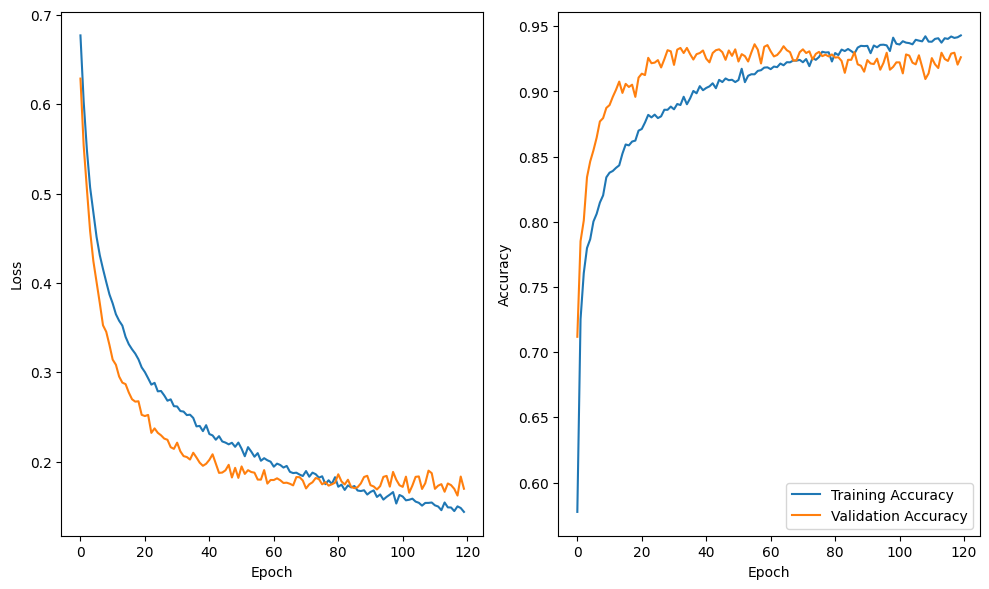

In [47]:
# Plot the losses

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].plot(loss_train, label='Training Loss')
axes[0].plot(loss_valid, label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

axes[1].plot(acc_train, label='Training Accuracy')
axes[1].plot(acc_valid, label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')

plt.legend()
plt.tight_layout()
plt.show()

In [48]:
# With the current model predict some instances
import torch

threshold = 0.5

tot_pred = []
tot_lab = []
pred_prob = []

for instance in validation_dataloader:
    X_val = instance[:-1][0]
    label = instance[-1]

    with torch.no_grad():
        output = MLP_model.forward(X_val.cuda(0))

    binary_pred = [int(x > threshold) for x in output]
    tot_pred.extend(binary_pred)

    tot_lab.extend(label.cpu().numpy())

    for bin_pred, true, pred in zip(binary_pred, label, output):
        
        pred_prob.append(pred.float().cpu().numpy()[0])
        match = "✔" if bin_pred == true else "✘"
        print(f"Pred Vs Label: {bin_pred} Vs {true} {match}, predicted output: {pred.float().cpu().numpy()[0]:.3f}")

print(f'Total accuracy: {accuracy_score(tot_pred, tot_lab):.2f}')


Pred Vs Label: 0 Vs 0 ✔, predicted output: 0.248
Pred Vs Label: 0 Vs 0 ✔, predicted output: 0.017
Pred Vs Label: 1 Vs 1 ✔, predicted output: 0.851
Pred Vs Label: 0 Vs 0 ✔, predicted output: 0.012
Pred Vs Label: 0 Vs 0 ✔, predicted output: 0.002
Pred Vs Label: 1 Vs 1 ✔, predicted output: 0.959
Pred Vs Label: 0 Vs 0 ✔, predicted output: 0.055
Pred Vs Label: 0 Vs 0 ✔, predicted output: 0.000
Pred Vs Label: 1 Vs 1 ✔, predicted output: 0.873
Pred Vs Label: 0 Vs 0 ✔, predicted output: 0.111
Pred Vs Label: 0 Vs 0 ✔, predicted output: 0.000
Pred Vs Label: 0 Vs 0 ✔, predicted output: 0.000
Pred Vs Label: 1 Vs 0 ✘, predicted output: 0.624
Pred Vs Label: 0 Vs 0 ✔, predicted output: 0.000
Pred Vs Label: 0 Vs 0 ✔, predicted output: 0.000
Pred Vs Label: 0 Vs 0 ✔, predicted output: 0.009
Pred Vs Label: 1 Vs 1 ✔, predicted output: 0.959
Pred Vs Label: 0 Vs 0 ✔, predicted output: 0.022
Pred Vs Label: 0 Vs 1 ✘, predicted output: 0.156
Pred Vs Label: 0 Vs 0 ✔, predicted output: 0.127
Pred Vs Label: 0 Vs 

<Axes: >

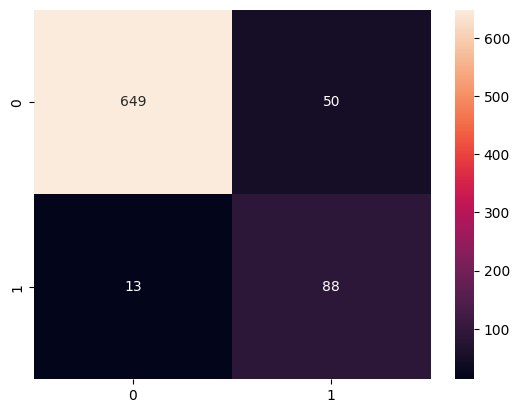

In [49]:
# Plot confusion matrix to check false positives and false negatives

from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(tot_lab, tot_pred)

sns.heatmap(conf_matrix,annot=True, fmt = 'g')


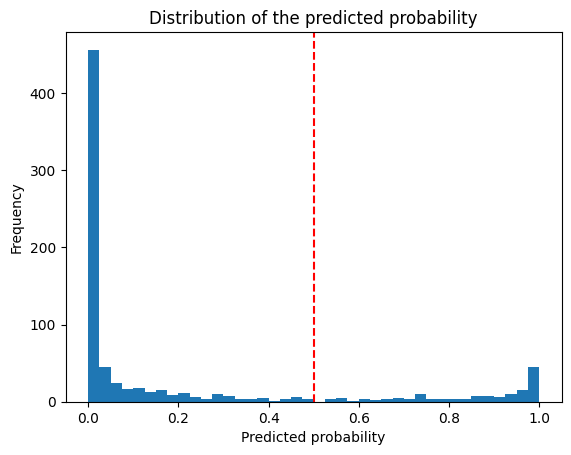

In [188]:
# plot the distribution of the predicted probability

import matplotlib.pyplot as plt

plt.hist(pred_prob, bins=40)
plt.axvline(x=0.5, color='red', linestyle='--')
plt.xlabel('Predicted probability')
plt.ylabel('Frequency')
plt.title('Distribution of the predicted probability')
plt.show()

### Multiclass Classification

In [189]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import pandas as pd

data = pd.read_csv('data/air_quality/pollution.csv')
print(data.head())

   Temperature  Humidity  PM2.5  PM10   NO2   SO2    CO  \
0         29.8      59.1    5.2  17.9  18.9   9.2  1.72   
1         28.3      75.6    2.3  12.2  30.8   9.7  1.64   
2         23.1      74.7   26.7  33.8  24.4  12.6  1.63   
3         27.1      39.1    6.1   6.3  13.5   5.3  1.15   
4         26.5      70.7    6.9  16.0  21.9   5.6  1.01   

   Proximity_to_Industrial_Areas  Population_Density Air Quality  
0                            6.3                 319    Moderate  
1                            6.0                 611    Moderate  
2                            5.2                 619    Moderate  
3                           11.1                 551        Good  
4                           12.7                 303        Good  


In [190]:
# Change Air quality from object to numeric value

air_quality = ['Hazardous', 'Poor', 'Moderate', 'Good']

data['Air Quality'] = data['Air Quality'].replace(air_quality, [0, 1, 2, 3])
data['Air Quality'] = data['Air Quality'].astype('int')


# Display a portion of the data

print(data['Air Quality'].head())


0    2
1    2
2    2
3    3
4    3
Name: Air Quality, dtype: int64


In [191]:
from sklearn.model_selection import train_test_split

X = data.drop('Air Quality', axis=1)
y = data['Air Quality']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=30)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=30)

print(f'Number of samples in training set: {X_train.shape[0]}')
print(f'Number of samples in validation set: {X_val.shape[0]}')

Number of samples in training set: 4000
Number of samples in validation set: 500


In [192]:
# Try and rebalance the data by oversampling the minority classes

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=30)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
X_test_sm, y_test_sm = smote.fit_resample(X_test, y_test)

In [193]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_sm) 
X_test = scaler.transform(X_test_sm)
X_val = scaler.transform(X_val)

print(f'The length of the training dataset is: {len(X_train)}')
print(f'The length of the testing dataset is: {len(X_test)}')
print(f'The length of the validation dataset is: {len(X_val)}')

The length of the training dataset is: 6444
The length of the testing dataset is: 796
The length of the validation dataset is: 500


In [194]:
# Print one example of the observations:

print(f'variables: {X_train[0]} \n and target: {y_train_sm[0]}')

variables: [-0.79613145  1.47245708 -0.84727251 -0.5159942   0.51877226  0.04904326
  0.40750162 -0.18344172  1.02675971] 
 and target: 1


In [195]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class MultiClass(Dataset):
    
    def __init__(self, X, y):

        self.X = X
        self.y = y
        
    def __len__(self):

        return len(self.X)
    
    def __getitem__(self, idx):

        return self.X[idx], self.y[idx]


In [196]:
# Create the dataset

train_dataset = MultiClass(X_train, y_train_sm) # X_train_sm --> y_train_sm, X_train_us --> y_train_sm, X_train
test_dataset = MultiClass(X_test, y_test_sm)   # X_test_sm --> y_test_sm, X_test_us --> y_test_sm, X_test
val_dataset = MultiClass(X_val, y_val)

print(f'One sample of the dataset is: {test_dataset[0]}')

One sample of the dataset is: (array([-1.17208063e-03, -1.01062916e+00, -3.03492204e-01, -2.35705291e-01,
       -1.15450907e+00, -7.91720751e-01, -1.16069027e-01,  8.36824352e-01,
       -1.20278767e+00]), 2)


In [197]:
# Implement the Multilayer PErceptron
import torch.nn as nn
import torch.nn.functional as F

class MultiClassifier(nn.Module):
  def __init__(self, input_size):
    super(MultiClassifier, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(input_size, 64), # Linear layer
        nn.ReLU(),                 # Relu activation function
        nn.Dropout(0.3),           # Dropout layer with 30% probability                                                
        nn.Linear(64, 64),
        nn.BatchNorm1d(64),        # Batch Normalization layer
        nn.ReLU(),                                                       
        nn.Linear(64, 4),         # Linear layer with one neuron as output       
    )

  def forward(self, x):
    return self.model(x)

  
  def init_weights(self):
    for layer in self.model:
      if isinstance(layer, nn.Linear):
        #nn.init.xavier_uniform_(layer.weight) # Initialize weights with xavier uniform
        #nn.init.kaiming_normal_(layer.weight) # Initialize weights with kaiming normal
        nn.init.kaiming_uniform(layer.weight) # Initialize weights with kaiming uniform
        #nn.init.zeros_(layer.bias)        

In [198]:
from sklearn.metrics import accuracy_score

def fit_multiclassifier(model, dataloader, optimizer, criterion, phase):
  
  if phase == 'training':
    model.train()
  else:
    model.eval()

  running_loss = []
  running_accuracy = []
  for i, data in enumerate(dataloader):

    input = data[0].float().cuda(0)
    label = data[1].view(-1).long().cuda(0)

    if phase == 'training':
      optimizer.zero_grad()

    predictions = model(input)
    preds = torch.argmax(predictions, dim=1)
    
    loss = criterion(predictions, label)
    running_loss.append(loss.item())
    running_accuracy.append(accuracy_score(preds.cpu().numpy(), label.cpu().numpy()))
    
    if phase == 'training':
      loss.backward()         # Backpropagation
      optimizer.step()        # Update weights

  # Computing loss and accuracy
  total_loss = np.asarray(running_loss).mean()
  total_acc = np.asarray(running_accuracy).mean()

  return total_loss, total_acc

In [199]:
# Training proccess
import warnings
import sys
import time
warnings.filterwarnings("ignore")

input_size = X_train.shape[1]
num_epochs = 120
num_workers = 16
batch_size = 64

criterion = nn.CrossEntropyLoss()

learning_rate = 1e-4 # 1e-2
threshold = 0.5

# Load the data
training_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Load the model and the optimizer
mutliclass_model = MultiClassifier(input_size)
mutliclass_model.cuda(0)

optimizer = torch.optim.AdamW(mutliclass_model.parameters(), lr = learning_rate, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=80, verbose=True)

loss_train = []
loss_valid = []

acc_train = []
acc_valid = []

prev_loss = []
 
# Learning forward loop
zero_time = time.time()
start_time = time.time()
for epoch in range(num_epochs):
    
    train_loss, train_acc = fit_multiclassifier(mutliclass_model, training_dataloader, optimizer, criterion, 'training')
    loss_train.append(train_loss), acc_train.append(train_acc)
    
    sys.stdout.flush()

    sys.stdout.write(f'Epoch {epoch + 1}/{num_epochs}, computed in {(time.time() - start_time):.3f} \n')
    start_time = time.time()

    sys.stdout.write(f'Training --> Loss: {train_loss:.3f}, Accuracy: {train_acc:.3f} \n')

    test_loss, test_acc = fit_multiclassifier(mutliclass_model, test_dataloader, optimizer, criterion, 'testing')
    loss_valid.append(test_loss), acc_valid.append(test_acc)

    scheduler.step(test_loss)  

    sys.stdout.write(f'Testing --> Loss: {test_loss:.3f}, Accuracy: {test_acc:.3f} \n\n')


print(f'Training completed in {((time.time() - zero_time)/70):.2} minutes')

Epoch 1/120, computed in 1.670 
Training --> Loss: 1.303, Accuracy: 0.377 
Testing --> Loss: 1.087, Accuracy: 0.646 

Epoch 2/120, computed in 2.235 
Training --> Loss: 0.993, Accuracy: 0.652 
Testing --> Loss: 0.849, Accuracy: 0.839 

Epoch 3/120, computed in 2.097 
Training --> Loss: 0.823, Accuracy: 0.745 
Testing --> Loss: 0.709, Accuracy: 0.863 

Epoch 4/120, computed in 2.405 
Training --> Loss: 0.714, Accuracy: 0.786 
Testing --> Loss: 0.601, Accuracy: 0.888 

Epoch 5/120, computed in 2.590 
Training --> Loss: 0.642, Accuracy: 0.811 
Testing --> Loss: 0.519, Accuracy: 0.900 

Epoch 6/120, computed in 2.482 
Training --> Loss: 0.578, Accuracy: 0.833 
Testing --> Loss: 0.471, Accuracy: 0.906 

Epoch 7/120, computed in 2.508 
Training --> Loss: 0.528, Accuracy: 0.846 
Testing --> Loss: 0.425, Accuracy: 0.917 

Epoch 8/120, computed in 2.283 
Training --> Loss: 0.485, Accuracy: 0.858 
Testing --> Loss: 0.375, Accuracy: 0.924 



KeyboardInterrupt: 

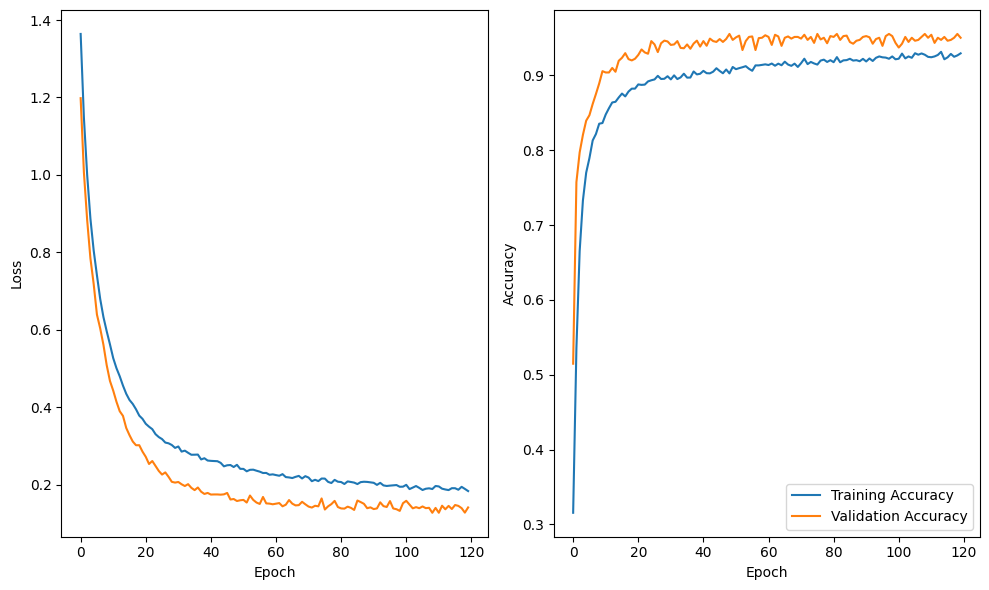

In [ ]:
# Plot the losses

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].plot(loss_train, label='Training Loss')
axes[0].plot(loss_valid, label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

axes[1].plot(acc_train, label='Training Accuracy')
axes[1].plot(acc_valid, label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# With the current model predict some instances
import torch

tot_pred = []
tot_lab = []
pred_prob = []

for i, instance in enumerate(test_dataloader):

    X_val = instance[0].float()
    label = instance[1].view(-1).numpy()

    with torch.no_grad():
        output = mutliclass_model.forward(X_val.cuda(0))

    preds = torch.argmax(output, dim=1).cpu().numpy()
    
    tot_pred.extend(preds)
    tot_lab.extend(label)

    for true, pred in zip(label, preds):
        
        match = "✔" if pred == true else "✘"
        print(f"Pred Vs Label: {pred} Vs {true} {match}, predicted output: {pred.item()}")

print(f'Total accuracy: {accuracy_score(tot_pred, tot_lab):.2f}')

[3 1 3 3 2 0 3 2 2 1 3 0 2 0 3 1 1 0 2 2 0 2 1 2 2 3 2 2 3 1 1 3 1 3 0 3 2
 0 1 2 0 0 2 0 2 2 2 2 0 0 3 2 2 2 2 0 1 2 3 1 2 3 1 1 2 2 3 0 2 1 2 1 3 0
 3 3 2 0 1 2 0 3 0 0 3 2 2 3 0 1 2 0 0 2 2 3 0 2 2 2 3 3 1 3 2 0 3 3 1 1 2
 3 1 2 1 2 2 3 2 1 1 3 2 3 3 3 3 3]
[3 1 3 3 2 0 3 2 2 1 3 0 2 0 3 0 1 0 2 2 1 2 1 2 2 3 2 2 3 1 1 3 1 3 0 3 2
 0 1 2 0 0 2 0 2 2 2 2 1 0 3 2 2 2 2 0 2 2 3 1 2 3 1 1 2 2 3 0 2 1 2 1 3 1
 3 3 2 0 1 2 0 3 0 0 3 2 2 3 0 1 2 0 0 2 2 3 0 2 2 2 3 3 1 3 2 0 3 3 1 1 2
 3 1 2 1 2 2 3 2 1 1 3 2 3 3 3 3 3]
Pred Vs Label: 3 Vs 3 ✔, predicted output: 3
Pred Vs Label: 1 Vs 1 ✔, predicted output: 1
Pred Vs Label: 3 Vs 3 ✔, predicted output: 3
Pred Vs Label: 3 Vs 3 ✔, predicted output: 3
Pred Vs Label: 2 Vs 2 ✔, predicted output: 2
Pred Vs Label: 0 Vs 0 ✔, predicted output: 0
Pred Vs Label: 3 Vs 3 ✔, predicted output: 3
Pred Vs Label: 2 Vs 2 ✔, predicted output: 2
Pred Vs Label: 2 Vs 2 ✔, predicted output: 2
Pred Vs Label: 1 Vs 1 ✔, predicted output: 1
Pred Vs Label: 3 Vs 3 ✔, pre